<a href="https://colab.research.google.com/github/pilgyeong/review-sentiment-anly/blob/main/sentiment_lstm_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 환경설정
- Google Drive Mount
- Settings for Data Visualization
- Import default library
- Load Dataset

In [ ]:
'''=================='''
'''Google Drive Mount'''
'''=================='''

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
'''==============================='''
'''Settings for Data Visualization'''
'''==============================='''

# 시스템 환경에 따른 기본폰트 설정하는 함수
def get_font_family():
  import platform
  systemName = platform.system()
  if systemName == 'Darwin':
    font_family = 'AppleGothic'
  elif systemName == 'Windows':
    font_family = 'Malgun Gothic'
  else:
    # Linux
    !apt-get install fonts-nanum -qq  > /dev/null
    !fc-cache -fv
    import matplotlib as mpl
    mpl.font_manager._rebuild()
    findfont = mpl.font_manager.fontManager.findfont
    mpl.font_manager.findfont = findfont
    mpl.backends.backend_agg.findfont = findfont
    font_family = "NanumBarunGothic"
  return font_family

# 시각화 유형별 스타일 설정
import matplotlib.pyplot as plt
font_family = get_font_family()
plt.style.use("ggplot")
plt.rc("font", family=font_family)
plt.rc("axes", unicode_minus=False)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [6]:
'''======================'''
'''Import default library'''
'''======================'''

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Mecab

# fit
mecab = Mecab()

## 1. 데이터 로드

In [7]:
train = pd.read_table('/content/drive/MyDrive/Colab Notebooks/movieReview_NLP/sentiment-nsmc/data/nsmc_train.txt')
test = pd.read_table('/content/drive/MyDrive/Colab Notebooks/movieReview_NLP/sentiment-nsmc/data/nsmc_test.txt')

In [8]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [10]:
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (150000, 3)
test shape: (50000, 3)


## 2. EDA

In [11]:
# null값 확인
print(f'train null개수: {train.isnull().sum()}')
print(f'test null개수: {test.isnull().sum()}')

train null개수: id          0
document    5
label       0
dtype: int64
test null개수: id          0
document    3
label       0
dtype: int64


In [12]:
# 라벨링 비율 확인
train['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [13]:
test['label'].value_counts()

1    25173
0    24827
Name: label, dtype: int64

## 3. 전처리

In [14]:
tokenizer = Mecab()

def preprocess(train, test):
    train.drop_duplicates(subset=['document'], inplace=True)
    test.drop_duplicates(subset=['document'], inplace=True)
    train = train.dropna()
    test = test.dropna()
    print(f"train shape => {train.shape} \ntest shape => {test.shape}")
    
    train_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in train['document']]
    test_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in test['document']]
    
    exclusion_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC',
                      'SF', 'SP', 'SS', 'SE', 'SO', 'EF', 'EP', 'EC', 'ETN', 'ETM',
                      'XSN', 'XSV', 'XSA']
    
    f = lambda x: x in exclusion_tags
    
    X_train = []
    for i in range(len(train_tokenized)):
        temp = []
        for j in range(len(train_tokenized[i])):
            if f(train_tokenized[i][j].split('/')[1]) is False:
                temp.append(train_tokenized[i][j].split('/')[0])
        X_train.append(temp)
    
    X_test = []
    for i in range(len(test_tokenized)):
        temp = []
        for j in range(len(test_tokenized[i])):
            if f(test_tokenized[i][j].split('/')[1]) is False:
                temp.append(test_tokenized[i][j].split('/')[0])
        X_test.append(temp)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(30000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train['label'])), X_test, np.array(list(test['label'])), word_to_index

In [15]:
X_train, y_train, X_test, y_test, word_to_index = preprocess(train, test)

train shape => (146182, 3) 
test shape => (49157, 3)


In [16]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [17]:
data = list(X_train)+list(X_test)

tokens_num = [len(tokens) for tokens in data]
tokens_num = np.array(tokens_num)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(tokens_num)}")
print(f"토큰 길이 최대: {np.max(tokens_num)}")
print(f"토큰 길이 표준편차: {np.std(tokens_num)}")

tokens_max = np.mean(tokens_num) + 2 * np.std(tokens_num)
maxlen = int(tokens_max)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(tokens_num < tokens_max) / len(tokens_num)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 12.248552516394575
토큰 길이 최대: 115
토큰 길이 표준편차: 9.88548851517802
설정 최대 길이: 32
전체 문장의 0.9372014805031254%가 설정값인 32에 포함됩니다.


In [18]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='pre', \
                                                        value=word_to_index[""], maxlen=70)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='pre', \
                                                       value=word_to_index[""], maxlen=70)

In [19]:
print(f"X_train 1번째 값 길이 : {len(X_train[0])}\nX_test 1번째 값 길이 : {len(X_test[0])}")

X_train 1번째 값 길이 : 70
X_test 1번째 값 길이 : 70


## 4. 모델링

### 4-1. LSTM

In [20]:
vocab_size = 30000
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          480000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 480,809
Trainable params: 480,809
Non-trainable params: 0
_________________________________________________________________


In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                  stratify=y_train, random_state=777)

In [22]:
history = model.fit(X_train, y_train, epochs=10, batch_size=512,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
229/229 [==============================] - 10s 11ms/step - loss: 0.5185 - accuracy: 0.7753 - val_loss: 0.3867 - val_accuracy: 0.8320
Epoch 2/10
229/229 [==============================] - 2s 8ms/step - loss: 0.3424 - accuracy: 0.8590 - val_loss: 0.3606 - val_accuracy: 0.8424
Epoch 3/10
229/229 [==============================] - 2s 9ms/step - loss: 0.3019 - accuracy: 0.8787 - val_loss: 0.3605 - val_accuracy: 0.8426
Epoch 4/10
229/229 [==============================] - 2s 9ms/step - loss: 0.2770 - accuracy: 0.8908 - val_loss: 0.3656 - val_accuracy: 0.8424
Epoch 5/10
229/229 [==============================] - 2s 9ms/step - loss: 0.2581 - accuracy: 0.9003 - val_loss: 0.3767 - val_accuracy: 0.8390
Epoch 6/10
229/229 [==============================] - 2s 9ms/step - loss: 0.2429 - accuracy: 0.9069 - val_loss: 0.3886 - val_accuracy: 0.8388
Epoch 7/10
229/229 [==============================] - 2s 8ms/step - loss: 0.2292 - accuracy: 0.9135 - val_loss: 0.4012 - val_accuracy: 0.8375
Epoc

In [23]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 6s 4ms/step - loss: 0.4353 - accuracy: 0.8348
[0.4353042542934418, 0.8348353505134583]


In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


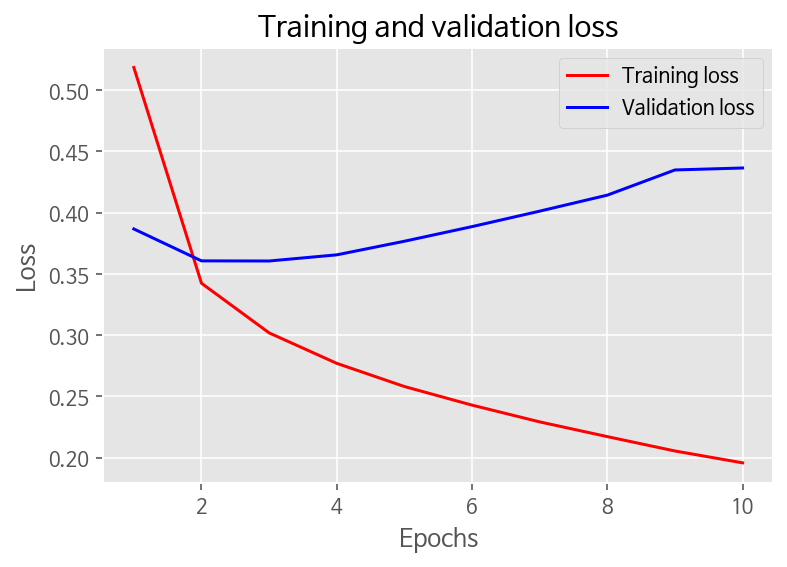

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 4-2. Stacked LSTM

In [26]:
vocab_size = 30000
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8, return_sequences = True))
model.add(tf.keras.layers.LSTM(units=16, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          480000    
                                                                 
 lstm_1 (LSTM)               (None, None, 8)           800       
                                                                 
 lstm_2 (LSTM)               (None, 16)                1600      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 482,417
Trainable params: 482,417
Non-trainable params: 0
_________________________________________________________________


In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                  stratify=y_train, random_state=42)

In [28]:
history = model.fit(X_train, y_train, epochs=10, batch_size=512,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
183/183 [==============================] - 6s 16ms/step - loss: 0.5477 - accuracy: 0.7417 - val_loss: 0.4181 - val_accuracy: 0.8190
Epoch 2/10
183/183 [==============================] - 2s 12ms/step - loss: 0.3550 - accuracy: 0.8528 - val_loss: 0.3643 - val_accuracy: 0.8424
Epoch 3/10
183/183 [==============================] - 2s 12ms/step - loss: 0.3010 - accuracy: 0.8783 - val_loss: 0.3612 - val_accuracy: 0.8457
Epoch 4/10
183/183 [==============================] - 2s 12ms/step - loss: 0.2698 - accuracy: 0.8937 - val_loss: 0.3730 - val_accuracy: 0.8438
Epoch 5/10
183/183 [==============================] - 2s 12ms/step - loss: 0.2447 - accuracy: 0.9057 - val_loss: 0.3895 - val_accuracy: 0.8399
Epoch 6/10
183/183 [==============================] - 2s 11ms/step - loss: 0.2251 - accuracy: 0.9145 - val_loss: 0.4003 - val_accuracy: 0.8363
Epoch 7/10
183/183 [==============================] - 2s 11ms/step - loss: 0.2096 - accuracy: 0.9223 - val_loss: 0.4191 - val_accuracy: 0.8350

In [29]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 11s 7ms/step - loss: 0.4886 - accuracy: 0.8272
[0.4885985553264618, 0.8272473812103271]


In [30]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


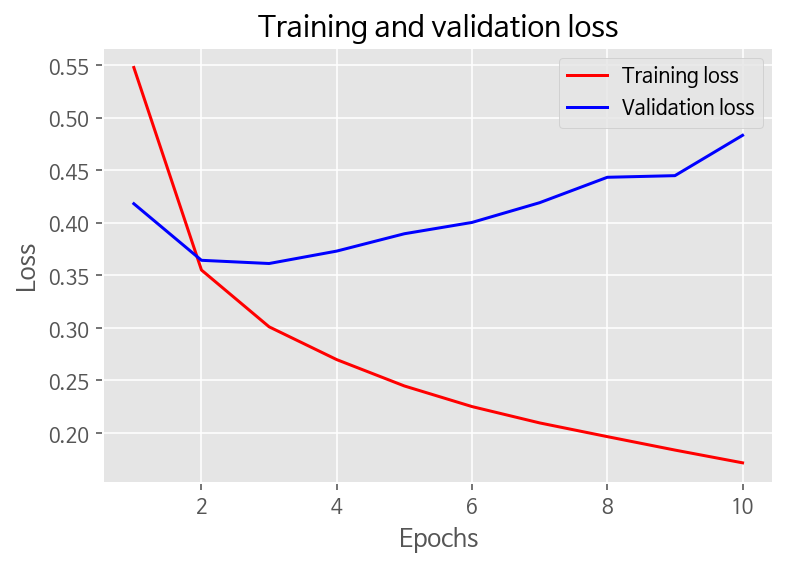

In [31]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 4-3. CNN

In [32]:
vocab_size = 30000
word_vector_dim = 32

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          960000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          2576      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1296      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 16)               

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                  stratify=y_train, random_state=42)

In [34]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    batch_size=512, epochs=10, verbose=1)

Epoch 1/10
147/147 [==============================] - 7s 9ms/step - loss: 0.6423 - accuracy: 0.6354 - val_loss: 0.5092 - val_accuracy: 0.7909
Epoch 2/10
147/147 [==============================] - 1s 6ms/step - loss: 0.4495 - accuracy: 0.8117 - val_loss: 0.4093 - val_accuracy: 0.8128
Epoch 3/10
147/147 [==============================] - 1s 6ms/step - loss: 0.3588 - accuracy: 0.8552 - val_loss: 0.4101 - val_accuracy: 0.8146
Epoch 4/10
147/147 [==============================] - 1s 6ms/step - loss: 0.3027 - accuracy: 0.8830 - val_loss: 0.4270 - val_accuracy: 0.8118
Epoch 5/10
147/147 [==============================] - 1s 7ms/step - loss: 0.2534 - accuracy: 0.9043 - val_loss: 0.4589 - val_accuracy: 0.8031
Epoch 6/10
147/147 [==============================] - 1s 9ms/step - loss: 0.2124 - accuracy: 0.9202 - val_loss: 0.5034 - val_accuracy: 0.8055
Epoch 7/10
147/147 [==============================] - 1s 9ms/step - loss: 0.1815 - accuracy: 0.9316 - val_loss: 0.5385 - val_accuracy: 0.8026
Epoch 

In [35]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 8s 5ms/step - loss: 0.6910 - accuracy: 0.7932
[0.6909631490707397, 0.7932339310646057]


In [36]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


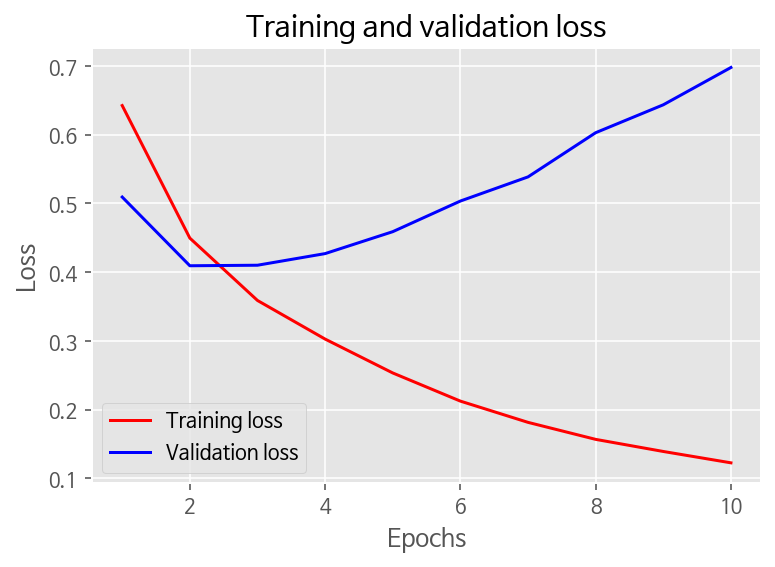

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()